### Imports

In [1]:
from src.database_connect import query_df
from src.panda_helpers import pd, get_unique_sort, sort_dict
from src.plot_helpers import millions, thousands
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import datetime
import numpy as np

/home/markus/Desktop/Data Scientist/3. SQL/2. Examinerande_Uppgift/src/database_connect.py:19: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


Connection to SQL server successful!


# Task 1 - Number of products per category

### Get all unique ID's for Category, Subcategory and Product

In [2]:
# Get all unique ProductCategory IDs
category_query = """
SELECT ProductCategoryID, Name
FROM Production.ProductCategory
"""

category_df = query_df(category_query).sort_values("ProductCategoryID").reset_index(drop=True)
productCategoryIDs = get_unique_sort(category_df, "ProductCategoryID")

# Get all unique ProductSubcategory IDs
subcategory_query = """
SELECT ProductSubcategoryID, ProductCategoryID
FROM Production.ProductSubcategory
"""
subcategory_df = query_df(subcategory_query).sort_values("ProductSubcategoryID").reset_index(drop=True)
productSubcategoryIDs = get_unique_sort(subcategory_df, "ProductSubcategoryID")

# Get all unique Product ID's
product_query = """
SELECT ProductID, ProductSubcategoryID
FROM Production.Product
"""

temp = query_df(product_query)
product_df = temp.dropna().sort_values("ProductID").reset_index(drop=True)
productIDs = get_unique_sort(product_df, "ProductID")

# Create dict for all unique ID's
unique_ids = {}
unique_ids["ProductCategoryID"] = list(productCategoryIDs)
unique_ids["ProductSubcategoryID"] = list(productSubcategoryIDs)
unique_ids["ProductID"] = list(productIDs)

### Group all Products to Subcategory

In [3]:
# Create a new DataFrame that contains a list of all product ID's for each Subcategory
# https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
categorized_products = product_df.groupby("ProductSubcategoryID")["ProductID"].apply(list).reset_index(name="ProductID")
categorized_products["ProductSubcategoryID"] = categorized_products["ProductSubcategoryID"].astype(int)
categorized_products.head()

,ProductSubcategoryID,ProductID
0,1,"[771, 772, 773, 774, 775, 776, 777, 778, 779, ..."
1,2,"[749, 750, 751, 752, 753, 754, 755, 756, 757, ..."
2,3,"[953, 954, 955, 956, 957, 958, 959, 960, 961, ..."
3,4,"[808, 809, 810, 811, 812, 813, 946, 947]"
4,5,"[994, 995, 996]"


### Group all Subcategories to Category

In [4]:
# Create a new DataFrame that contains a list of all Subcategory ID's for each Category
categorized_subcategories = subcategory_df.groupby("ProductCategoryID")["ProductSubcategoryID"].apply(list).reset_index(name="ProductSubcategoryID")
categorized_subcategories.head()

,ProductCategoryID,ProductSubcategoryID
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,3,"[18, 19, 20, 21, 22, 23, 24, 25]"
3,4,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]"


### Expand list of SubcategoryID with the ProductID's - CLEAN UP

In [5]:
# Join to df1 to get ProductID lists
merged = subcategory_df.merge(categorized_products, on='ProductSubcategoryID', how='left')

# Combine ProductID lists per ProductCategoryID
result = (
    merged
    .groupby('ProductCategoryID')['ProductID']
    .agg(lambda x: [pid for sublist in x for pid in sublist])
    .reset_index()
)

# Combine ProductID lists per ProductCategoryID
result_sub = (
    merged
    .groupby('ProductSubcategoryID')['ProductID']
    .agg(lambda x: [pid for sublist in x for pid in sublist])
    .reset_index()
)

#for i in result["ProductCategoryID"]:
#    print(f"Category {i} has {len(result["ProductID"].loc[i-1])} unique products.")

#result
#result_sub

### Graph

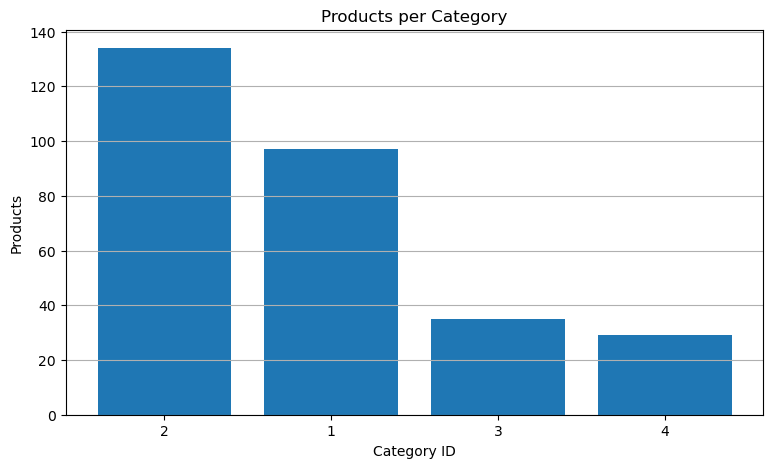

In [6]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in result["ProductCategoryID"]), (len(i) for i in result["ProductID"]))}  
sorted_data = sort_dict(data)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.bar(x, y)
plt.title("Products per Category")
plt.xlabel("Category ID")
plt.ylabel("Products")
plt.grid(axis="y")
plt.show()

## Conclusion Task 1:
Category 2 has the most products at 134 and Category 4 the least at 29
* Category 1: 97
* Category 2: 134
* Category 3: 35
* Category 4: 29

# Task 2 - Sales per category

### Create DataFrame with OrderQty, ProductID and UnitPrice

In [7]:
sales_query = """
SELECT OrderQty, ProductID, UnitPrice
FROM Sales.SalesOrderDetail
"""

sales_df = query_df(sales_query).sort_values("ProductID").reset_index(drop=True)
sales_df

,OrderQty,ProductID,UnitPrice
0,4,707,20.9940
1,4,707,20.9940
2,1,707,34.9900
3,4,707,20.9940
4,2,707,20.1865
...,...,...,...
121312,1,999,539.9900
121313,3,999,323.9940
121314,1,999,539.9900
121315,1,999,539.9900


### Sum OrderQty for each unique ProductID + UnitPrice

In [8]:
df_grouped = (
    sales_df
    .groupby(["ProductID", "UnitPrice"], as_index=False)
    .agg({"OrderQty": "sum"})
)

df_grouped

,ProductID,UnitPrice,OrderQty
0,707,15.7455,222
1,707,16.8221,162
2,707,18.5043,56
3,707,19.2445,66
4,707,19.5136,135
...,...,...,...
752,998,323.9940,1062
753,998,539.9900,363
754,999,313.1942,71
755,999,323.9940,881


### Calculate the revenue for each row and add new column for revenue

In [9]:
df_grouped["Revenue"] = df_grouped.UnitPrice * df_grouped.OrderQty

df_grouped

,ProductID,UnitPrice,OrderQty,Revenue
0,707,15.7455,222,3495.5010
1,707,16.8221,162,2725.1802
2,707,18.5043,56,1036.2408
3,707,19.2445,66,1270.1370
4,707,19.5136,135,2634.3360
...,...,...,...,...
752,998,323.9940,1062,344081.6280
753,998,539.9900,363,196016.3700
754,999,313.1942,71,22236.7882
755,999,323.9940,881,285438.7140


### Group by ProductID and sum revenue

In [10]:
df_revenue = (
    df_grouped
    .groupby(["ProductID"], as_index=False)
    .agg({"Revenue": "sum"})
)

df_revenue

,ProductID,Revenue
0,707,158865.9084
1,708,162076.7042
2,709,6147.6400
3,710,513.0000
4,711,166720.9076
...,...,...
261,994,12244.9320
262,996,39581.4420
263,997,290298.6240
264,998,579733.2640


### Combine ProductID's to ProductCategoryID and sum revenues - CLEAN UP

In [11]:
# Category df
df_result = (
    result
        .explode('ProductID')
        .merge(df_revenue, on='ProductID', how='left')
        .groupby('ProductCategoryID', as_index=False)['Revenue']
        .sum()
)
df_result = df_result.sort_values(by="Revenue", ascending=False).reset_index(drop=True)

# Subcategory df
df_result_sub = (
    result_sub
        .explode('ProductID')
        .merge(df_revenue, on='ProductID', how='left')
        .groupby('ProductSubcategoryID', as_index=False)['Revenue']
        .sum()
)
df_result_sub = df_result_sub.sort_values(by="Revenue", ascending=False).reset_index(drop=True)

#df_result_sub
#df_result

### Graph

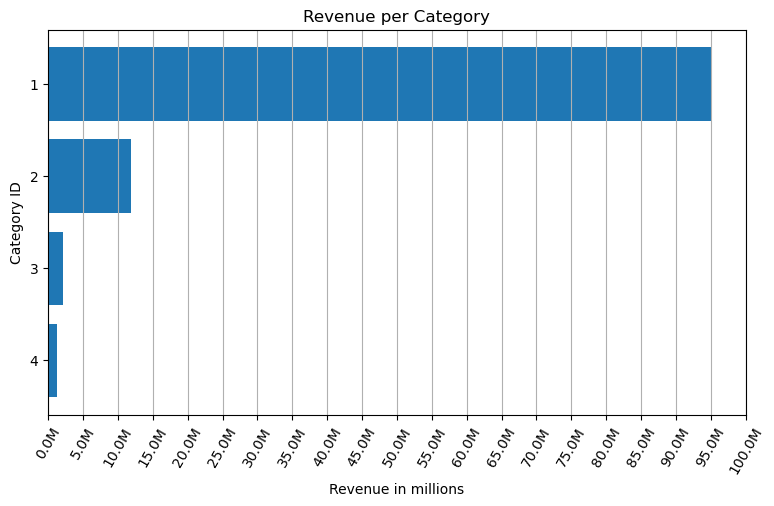

In [12]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in df_result["ProductCategoryID"]), (i for i in df_result["Revenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 100000001, 5000000)
plt.xticks(tick_pos, rotation=60)
plt.title("Revenue per Category")
plt.ylabel("Category ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

0.0


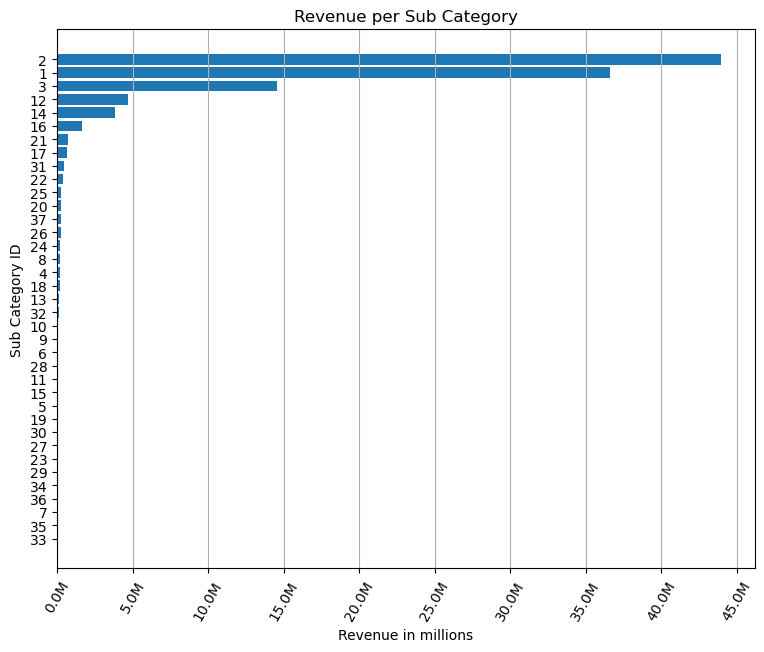

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))

data = { k:v for (k,v) in zip((str(i) for i in df_result_sub["ProductSubcategoryID"]), (i for i in df_result_sub["Revenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]
print(min(y))

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 45_000_001, 5_000_000)
plt.xticks(tick_pos, rotation=60)
plt.title("Revenue per Sub Category")
plt.ylabel("Sub Category ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

## Conclusion Task 2
Sub Category 2 has the most revenue at 43,978,443.2489 and Sub Category 33 has the least revenue at 0.0

# Task 3 - Sales trend over time

### Create dataframe of SalesOrderID and OrderDate

In [14]:
# Specify a query and get dataframe of OrderDates
order_query = """
SELECT SalesOrderID, OrderDate, SubTotal
FROM Sales.SalesOrderHeader
"""

order_df = query_df(order_query)
order_df

,SalesOrderID,OrderDate,SubTotal
0,43659,2022-05-30,20565.6206
1,43660,2022-05-30,1294.2529
2,43661,2022-05-30,32726.4786
3,43662,2022-05-30,28832.5289
4,43663,2022-05-30,419.4589
...,...,...,...
31460,75119,2025-06-29,42.2800
31461,75120,2025-06-29,84.9600
31462,75121,2025-06-29,74.9800
31463,75122,2025-06-29,30.9700


### Create new DataFrame containing the DateID as YYYY-MM, list of SalesOrderID's that occured that month and SubTotal

In [15]:
order_df["OrderDate"] = pd.to_datetime(order_df["OrderDate"])

monthly_order_df = (
    order_df
    .assign(DateID=order_df["OrderDate"].dt.to_period("M"))
    .groupby("DateID", as_index=False)
    .agg({"SalesOrderID": list, "SubTotal": "sum"})
)

monthly_order_df

,DateID,SalesOrderID,SubTotal
0,2022-05,"[43659, 43660, 43661, 43662, 43663, 43664, 436...",5.177374e+05
1,2022-06,"[43706, 43707, 43708, 43709, 43710, 43711, 437...",2.001279e+06
2,2022-07,"[43923, 43924, 43925, 43926, 43927, 43928, 439...",1.668510e+06
3,2022-08,"[44138, 44139, 44140, 44141, 44142, 44143, 441...",1.326138e+06
4,2022-09,"[44327, 44328, 44329, 44330, 44331, 44332, 443...",2.836410e+06
5,2022-10,"[44577, 44578, 44579, 44580, 44581, 44582, 445...",2.269438e+06
6,2022-11,"[44816, 44817, 44818, 44819, 44820, 44821, 448...",1.437343e+06
7,2022-12,"[45083, 45084, 45085, 45086, 45087, 45088, 450...",2.504196e+06
8,2023-01,"[45351, 45352, 45353, 45354, 45355, 45356, 453...",2.076792e+06
9,2023-02,"[45610, 45611, 45612, 45613, 45614, 45615, 456...",1.449883e+06


### Graph

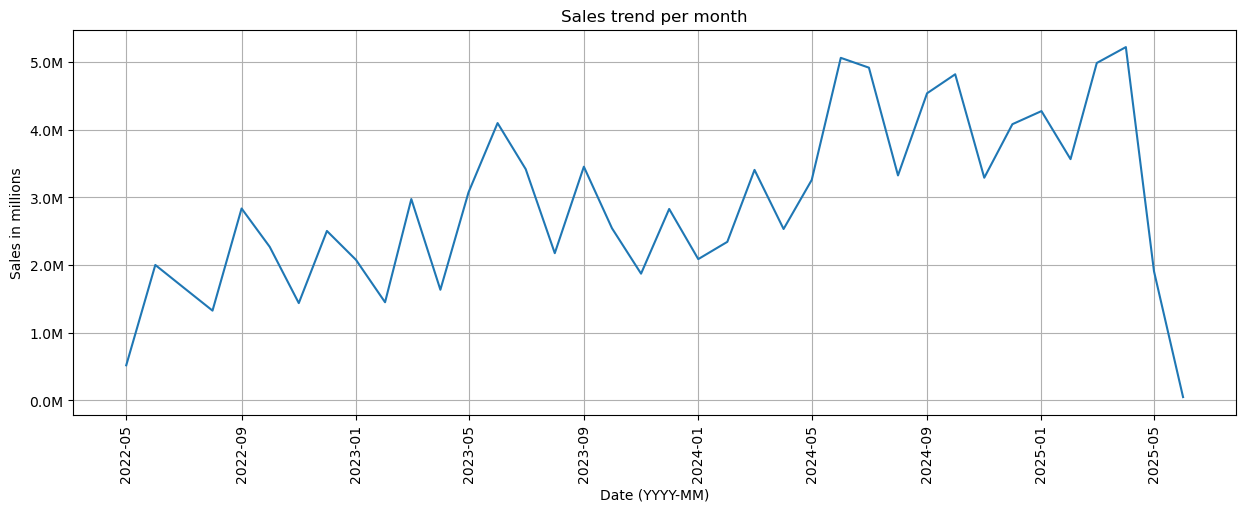

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))

#data = { k:v for (k,v) in zip((str(i) for i in monthly_order_df["DateID"]), (len(i) for i in monthly_order_df["SalesOrderID"]))}
data = { k:v for (k,v) in zip((str(i) for i in monthly_order_df["DateID"]), (i for i in monthly_order_df["SubTotal"]))}

x = [datetime.datetime.strptime(i, "%Y-%m") for i in data]
y = [data[i] for i in data]

plt.plot(x, y, linestyle="solid")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.xticks(rotation=90)
plt.title("Sales trend per month")
plt.ylabel("Sales in millions")
plt.xlabel("Date (YYYY-MM)")
plt.grid()
plt.show()

## Conclusion Task 3 - CLEAN UP

# Task 4 - Sales and number of orders per year

### Create DataFrame of TotalOrders and SubTotal grouped by year

In [17]:
order_df["OrderDate"] = pd.to_datetime(order_df["OrderDate"])

yearly_order_df = (
    order_df
    .assign(DateID=order_df["OrderDate"].dt.to_period("Y"))
    .groupby("DateID", as_index=False)
    .agg({"SalesOrderID": list, "SubTotal": "sum"})
)

yearly_order_df["SalesOrderID"] = yearly_order_df["SalesOrderID"].str.len().astype(int)
yearly_order_df = yearly_order_df.rename(columns={"SalesOrderID": "TotalOrders"})
yearly_order_df

,DateID,TotalOrders,SubTotal
0,2022,1692,1.456105e+07
1,2023,3830,3.160492e+07
2,2024,14244,4.367189e+07
3,2025,11699,2.000852e+07


### Graph

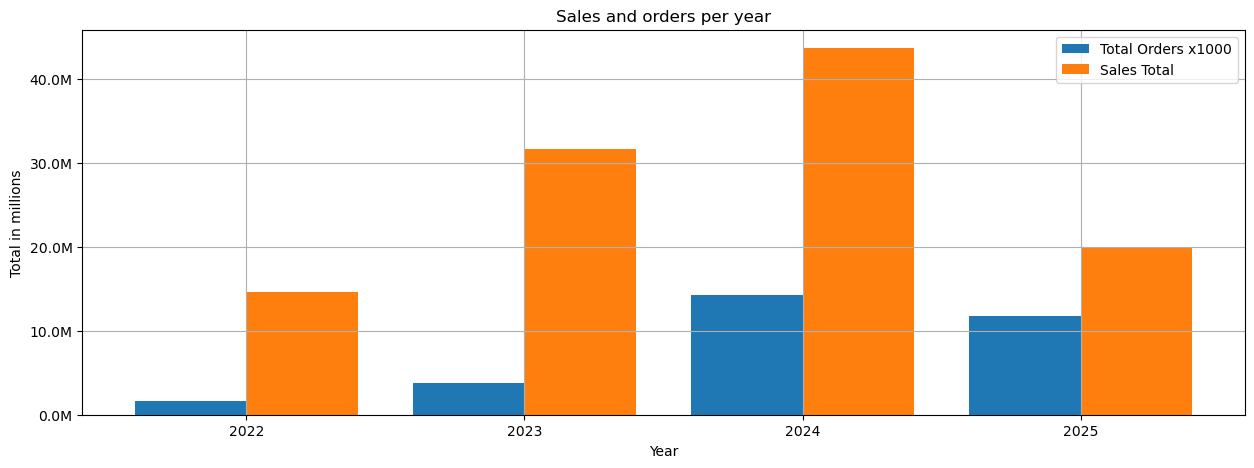

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

data = { k:v for (k,v) in zip((str(i) for i in yearly_order_df["DateID"]), (i for i in monthly_order_df["SubTotal"]))}

temp = [int(i) for i in data]
x = np.arange(min(temp), max(temp)+1, 1)
y1 = [i*1000 for i in yearly_order_df["TotalOrders"]]
y2 = [i for i in yearly_order_df["SubTotal"]]
w = 0.4

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.bar(x-0.2, y1, w)
plt.bar(x+0.2, y2, w)
plt.title("Sales and orders per year")
plt.ylabel("Total in millions")
plt.xlabel("Year")
plt.legend(["Total Orders x1000", "Sales Total"])
plt.grid()
plt.show()

## Conclusion Task 4
Year 2024 had the most sales and the most orders. Year 2022 had the least sales and the least orders.
Sales and number of orders appears to be related. More orders results in more sales which can be expected in general. It is not a guarantee as the case where there are a lot of orders but all orders have little sales value would show otherwise.
* **Year 2024** had the most sales and the most orders.
* **Year 2022** had the least sales and the least orders.

# Task 5 - Top 10 Products

### Create DataFrame of the top 10 products

In [19]:
# Specify a query to get the top 10 products. TotalRevenue is OrderQty * UnitPrice, group id by ProductID and sort in DESCENDING order
top10_query = """
SELECT TOP 10
    ProductID,
    SUM(OrderQty * UnitPrice) AS TotalRevenue
FROM Sales.SalesOrderDetail
GROUP BY ProductID
ORDER BY TotalRevenue DESC
"""

top10_df = query_df(top10_query)
top10_df

,ProductID,TotalRevenue
0,782,4.406151e+06
1,783,4.014068e+06
2,779,3.696486e+06
3,780,3.441293e+06
4,781,3.436091e+06
5,784,3.311098e+06
6,793,2.518300e+06
7,794,2.348246e+06
8,795,2.012448e+06
9,753,1.847819e+06


### Graph

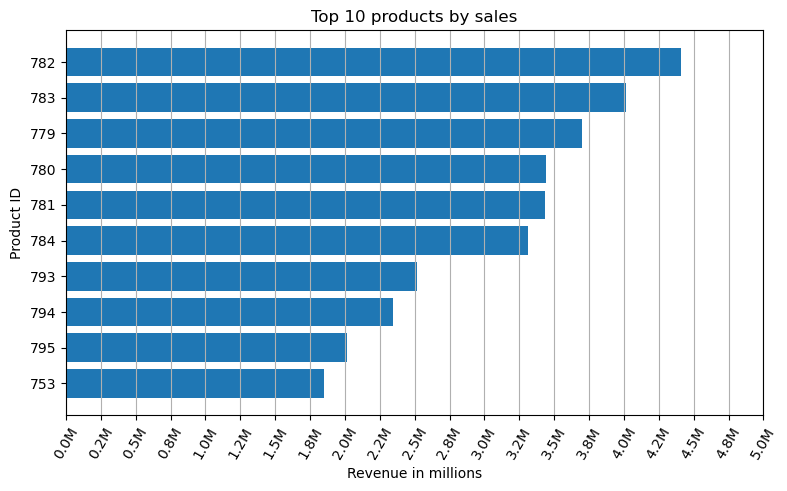

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in top10_df["ProductID"]), (i for i in top10_df["TotalRevenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 5_000_001, 250_000)
plt.xticks(tick_pos, rotation=60)
plt.title("Top 10 products by sales")
plt.ylabel("Product ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

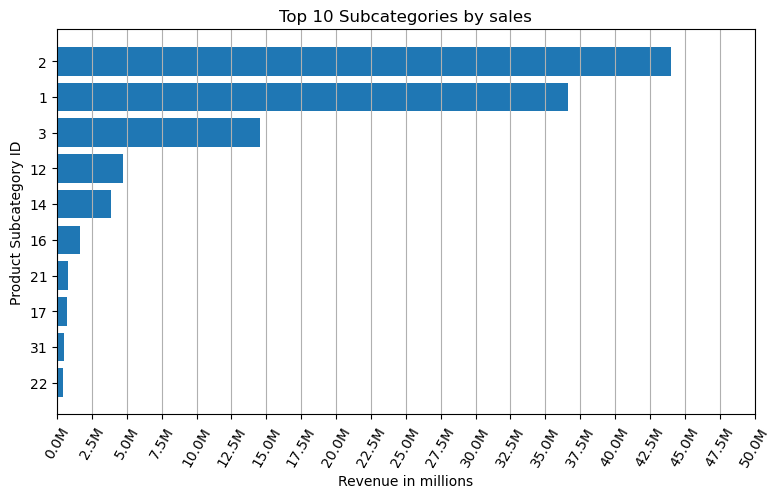

In [21]:
#df_result_sub

fig, ax = plt.subplots(figsize=(9, 5))

data = { k:v for (k,v) in zip((str(i) for i in df_result_sub.head(10)["ProductSubcategoryID"]), (i for i in df_result_sub.head(10)["Revenue"]))}  
sorted_data = sort_dict(data, False)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.barh(x, y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
tick_pos = range(0, 50_000_001, 2_500_000)
plt.xticks(tick_pos, rotation=60)
plt.title("Top 10 Subcategories by sales")
plt.ylabel("Product Subcategory ID")
plt.xlabel("Revenue in millions")
plt.grid(axis="x")
plt.show()

## Conclusion Task 5
Product 782 dominates the top 10 list at 4,406,151.2662 whereas Subcategory 2 dominates the top 10 list at 43,978,443.2489

# Task 6 - Sales and number of customers per region

### Create DataFrame of SalesOrderID, CustomerID, TerritoryID and SubTotal

In [22]:
sales_query = """
SELECT SalesOrderID, CustomerID, TerritoryID, SubTotal
FROM Sales.SalesOrderHeader
"""

sales_df2 = query_df(sales_query)
sales_df2

,SalesOrderID,CustomerID,TerritoryID,SubTotal
0,43659,29825,5,20565.6206
1,43660,29672,5,1294.2529
2,43661,29734,6,32726.4786
3,43662,29994,6,28832.5289
4,43663,29565,4,419.4589
...,...,...,...,...
31460,75119,11981,1,42.2800
31461,75120,18749,6,84.9600
31462,75121,15251,6,74.9800
31463,75122,15868,6,30.9700


### Group by CustomerID and make new column containing all SalesOrderID's in a list

In [97]:
customer_orders_df = (
    sales_df2
    .groupby("CustomerID", as_index=False)
    .agg({"SalesOrderID": list, "TerritoryID": "first", "SubTotal": "sum"})
)

# DataFrame with a list of Orders for each unique CustomerID and SubTotal
customer_orders_df

# Group by TerritoryID and get length of list of customers and SubTotal
territory_df = (
    customer_orders_df
    .groupby("TerritoryID", as_index=False)
    .agg({"TerritoryID": "first", "CustomerID": len, "SubTotal": "sum"})
)
territory_df.rename(columns={"CustomerID": "CustomerCount"}, inplace=True)
territory_df = territory_df.sort_values(by="SubTotal", ascending=False).reset_index(drop=True)
territory_df["TotalPerCustomer"] = territory_df["SubTotal"] / territory_df["CustomerCount"]

territory_df

,TerritoryID,CustomerCount,SubTotal,TotalPerCustomer
0,4,4565,2.418461e+07,5297.833428
1,6,1677,1.635577e+07,9752.993712
2,1,3428,1.608494e+07,4692.223614
3,9,3625,1.065534e+07,2939.403023
4,3,69,7.909009e+06,114623.318930
5,5,91,7.879655e+06,86589.616188
6,10,1951,7.670721e+06,3931.686846
7,7,1844,7.251556e+06,3932.513909
8,2,57,6.939374e+06,121743.411953
9,8,1812,4.915408e+06,2712.697349


### Graph

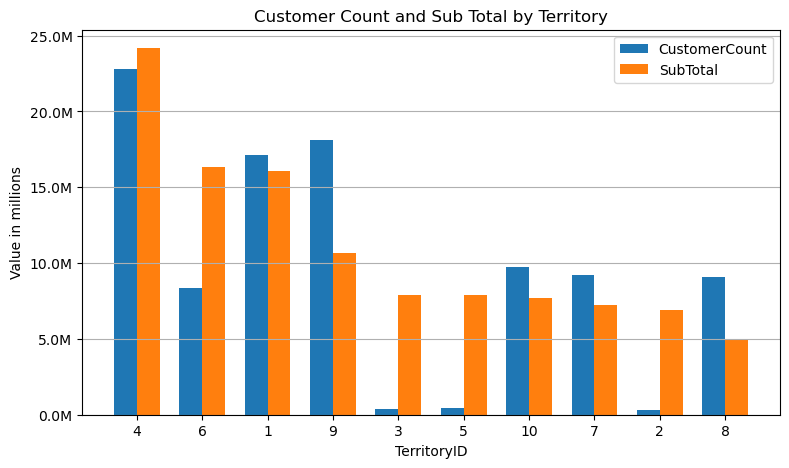

In [68]:
x = np.arange(len(territory_df))   # x locations
width = 0.35             # bar width

fig, ax = plt.subplots(figsize=(9, 5))

#plt.figure(figsize=(8, 5))

ax.bar(x - width/2, territory_df["CustomerCount"]*5000, width, label="CustomerCount")
ax.bar(x + width/2, territory_df["SubTotal"], width, label="SubTotal")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.set_xticks(x, territory_df["TerritoryID"])
ax.set_xlabel("TerritoryID")
ax.set_ylabel("Value in millions")
ax.set_title("Customer Count and Sub Total by Territory")
ax.grid(axis="y")
ax.legend()

plt.show()

## Conclusion Task 6
Territory 4 (Southwest, North America) has the most sales and the most customers.
Territory 2, 3, 5 are peculiar. They have the highest sales per customer.

# Task 6 - Average order value per region and customer type

In [ ]:
sales_query = """
SELECT SalesOrderID, SalesPersonID, CustomerID, TerritoryID, SubTotal
FROM Sales.SalesOrderHeader
"""

sales_df3 = query_df(sales_query)

# All orders where a SalesPersonID is present is a business order, the rest are individual
store_orders_df = sales_df3.copy().dropna()

# Group the SalesPersonID and sum nr of sales and SubTotal
sales_person_id_df2 = (
    store_orders_df
    .groupby("SalesPersonID", as_index=False)
    .agg({"SalesOrderID": len, "TerritoryID": "first", "SubTotal": "sum"})
)

sales_person_id_df2 = sales_person_id_df2.rename(columns={"SalesOrderID": "SalesCount"})

sales_person_id_df3 = (
    sales_person_id_df2
    .groupby("TerritoryID", as_index=False)
    .agg({"SalesCount": "sum", "SubTotal": "sum"})
)

# DataFrame containing Store Orders only. TerritoryID, SalesCount and SubTotal.
sales_person_id_df3 = sales_person_id_df3.sort_values(by="SubTotal", ascending=False).reset_index(drop=True)
sales_person_id_df3

# Since we know the Store and Individual combined we can subtract the Store from it and get the Individual orders.

,TerritoryID,SalesCount,SubTotal
0,3,923,1.935971e+07
1,6,853,1.803920e+07
2,4,660,1.679401e+07
3,1,472,1.045972e+07
4,5,429,7.171013e+06
5,7,214,5.242648e+06
6,8,130,1.827067e+06
7,9,125,1.594335e+06
